In [0]:
!nvidia-smi

Tue Mar 10 09:46:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  !cp "/content/gdrive/My Drive/bengali/gridmask.py" /content
except:
  print("Not colab runtime")

In [0]:
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms as torchtransforms
import cv2
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import time
import os
import pyarrow
from PIL import Image
import albumentations
from albumentations.pytorch import ToTensor
from albumentations.augmentations.transforms import Normalize
import gc
import json
import sklearn.metrics
import math

In [0]:
try:
  from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
except:
  !pip3 install iterative-stratification
  from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [0]:
import sys
from gridmask import GridMask

In [0]:
device = "cpu" # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
root_path="/content/gdrive/My Drive/bengali/bengaliai-cv19"

cpu


In [0]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [0]:
class ClsDataset(Dataset):
    def __init__(self, ids, images, labels, transform=None):
        self.labels = labels
        self.images = images
        self.ids = ids
        self.transform = transform

    def __getitem__(self, idx):
        image_id = self.ids[idx]
        img = self.images[idx]
        img = self.transform(image=img)
        image_tensor = img['image'].unsqueeze_(0)
        y = self.labels[idx, :]
        return image_id, image_tensor, y
    
    def __len__(self):
        return len(self.images)

def make_loader(ids, images, labels, batch_size=64,num_workers=2, is_shuffle=False, transform=None):
    image_dataset = ClsDataset(ids = ids, images = images, labels=labels, transform=transform)
    return DataLoader(image_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=is_shuffle)

In [0]:
def load_from_parquet():
  HEIGHT = 137
  WIDTH = 236
  ids_list = []
  ims_list = []
  for i in range(4):
      p = pd.read_parquet(os.path.join(root_path, f'{root_path}/train_image_data_{i}.parquet'), engine='pyarrow')
      ids = p.iloc[:, 0].copy().values
      ids_list.append(ids)
      ims = 255 - p.iloc[:, 1:].copy().values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
      ims_list.append(ims)
      print(ims.shape,ids.shape)
      del p
      gc.collect()
  ids_full = np.concatenate(ids_list, axis=0)
  ims_full = np.concatenate(ims_list, axis=0)
  del ids_list
  del ims_list
  gc.collect()
  return ids_full, ims_full

def cache_images(ims_full):
  ims_full_mm = np.memmap(f'train_image_data.numpy', dtype=np.uint8, mode='w+', shape=(200840, 137, 236))
  ims_full_mm[:] = ims_full[:]
  ims_full_mm.flush()
  del ims_full_mm
  !cp train_image_data.numpy "/content/gdrive/My Drive/bengali/bengaliai-cv19/"

def cache_ids(ids_full):
  with open(f'{root_path}/train_image_ids.json', 'w') as f:
      json.dump(ids_full.tolist(), f)

def load_caches():
  ims_full = np.memmap(f'{root_path}/train_image_data.numpy', dtype=np.uint8, mode='r', shape=(200840, 137, 236))
  with open(f'{root_path}/train_image_ids.json', 'r') as f:
      ids_full = np.array(json.load(f))
  return ids_full, ims_full

In [0]:
ids_full, ims_full = load_caches()

In [0]:
labels = pd.read_csv(os.path.join(root_path,'train.csv'))[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values

In [0]:
msss = MultilabelStratifiedShuffleSplit(n_splits=20, random_state=1231, test_size=0.1)
train_index, valid_index = next(msss.split(ids_full, labels))

In [0]:
%%time
train_ids = ids_full[train_index]
train_images = ims_full[train_index]
train_labels = labels[train_index]

val_ids = ids_full[valid_index]
val_images = ims_full[valid_index]
val_labels = labels[valid_index]

len(train_ids), len(val_ids)

CPU times: user 1.12 s, sys: 4.7 s, total: 5.83 s
Wall time: 2min 22s


In [0]:
len(train_ids), len(val_ids)

(180756, 20084)

In [0]:
del ims_full
del ids_full
del train_index, valid_index 
del msss
del labels
gc.collect()

92

In [0]:
batch_size = 128

train_loader = make_loader(ids=train_ids, images=train_images, labels=train_labels, batch_size=batch_size, num_workers=4, is_shuffle=True, transform=albumentations.Compose([
    albumentations.Resize(64, 110, 2), 
    albumentations.OneOf([
        GridMask(num_grid=3, p=0.9),
        GridMask(num_grid=(3, 6), rotate=10, p=0.9),
        GridMask(num_grid=4, p=0.9),
        GridMask(num_grid=5, rotate=5, p=0.9),
    ], p=1.0),
    Normalize(0.0465, 0.1708),
    ToTensor(),
]))

val_loader = make_loader(ids=val_ids, images=val_images, labels=val_labels, batch_size=batch_size, num_workers=4, is_shuffle=False, transform=albumentations.Compose([
    albumentations.Resize(64, 110, 2), 
    Normalize(0.0465, 0.1708),
    ToTensor(),
]))

In [0]:
RAND_SAMP_SIZE=16
rand_idx = np.random.permutation(train_labels.shape[0])[:RAND_SAMP_SIZE]
dbg_ids = train_ids[rand_idx]
dbg_images = train_images[rand_idx]
dbg_labels = train_labels[rand_idx]

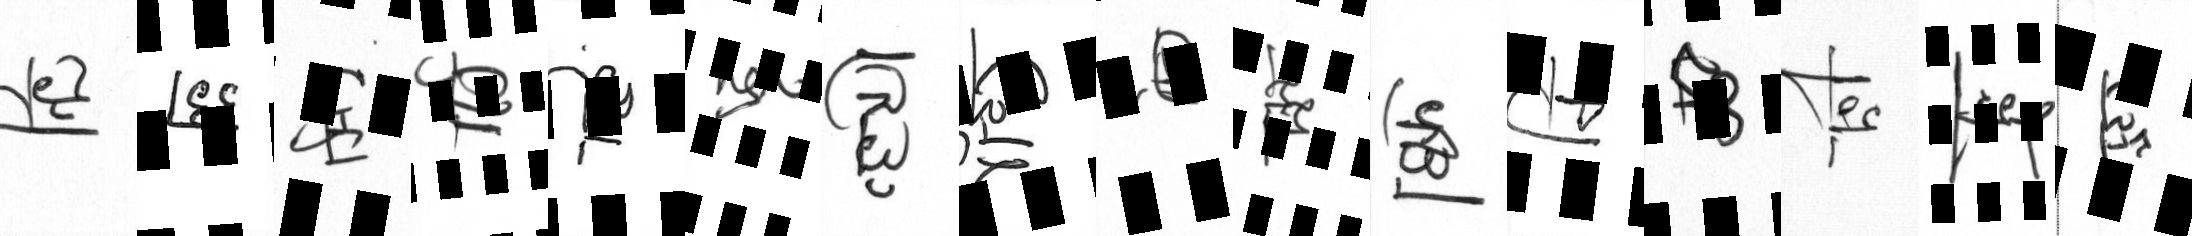

In [0]:
dbg_loader = make_loader(ids=dbg_ids, images=dbg_images, labels=dbg_labels, batch_size=RAND_SAMP_SIZE, num_workers=2, is_shuffle=True, transform=albumentations.Compose([
    #albumentations.Resize(64, 110, 2), 
    #albumentations.augmentations.transforms.RandomGamma(gamma_limit=(10,100)),
    albumentations.OneOf([
    #     GridMask(num_grid=3, p=1.0, fill_value=0),
        GridMask(num_grid=(2, 3), rotate=15,p=1.0, fill_value=0),
    #    GridMask(num_grid=4,p=0.7, fill_value=255),
    #    GridMask(num_grid=5, rotate=5,p=0.7, fill_value=255),
    ], p=0.7),
    ToTensor(), 
]))
for i, (imgid, batch, y) in enumerate(dbg_loader):
  bb = torch.cat([b for b in batch],2)
  pim = torchtransforms.ToPILImage()(bb)
pim

In [0]:
model = torch.hub.load('PingoLH/Pytorch-HarDNet', 'hardnet85', pretrained=False)
model.base[19][3] = nn.Linear(1280, 186)
model.load_state_dict(torch.load(f'{root_path}/bengali_res64x110_gm.hardnet85', map_location='cuda:0'))
model = model.to(device)

Using cache found in /root/.cache/torch/hub/PingoLH_Pytorch-HarDNet_master


In [0]:
model = model.to(device)

In [0]:
model = torch.hub.load('pytorch/vision:v0.5.0', 'densenet121', pretrained=False)
model.classifier = nn.Linear(1024, 186)
model.load_state_dict(torch.load(f'{root_path}/bengali_res64x110_gm.dense', map_location='cuda:0'))
#for param in model.parameters():
#    param.requires_grad = False
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [0]:
model = torch.hub.load('pytorch/vision:v0.5.0', 'googlenet', pretrained=True)
model.avgpool = nn.Flatten()
model.fc = nn.Linear(6144, 186)
model.load_state_dict(torch.load(f'{root_path}/bengali_res64x110_gm.gnet', map_location='cuda:0'))
for param in model.parameters():
    param.requires_grad = False
model = model.to(device)

In [0]:
def calc_metrics(target_y, outputs, classes_num, calc_cf = False):
    scores = []
    cfs = []
    for y, out,c in zip(target_y, outputs,classes_num):
        y_pred = out.argmax(1).cpu().detach().numpy()
        y_true = y.cpu().detach().numpy()
        scores.append(sklearn.metrics.recall_score(y_true, y_pred, average='macro'))
        if calc_cf:
          cf = sklearn.metrics.confusion_matrix(y_true,y_pred,labels=range(c))
          cfi = np.zeros((c,1), dtype=np.int64)
          for i in range(c):
            cfi[i,0] = cf[i,i]
            cf[i,i] = 0
          cfs.append(np.concatenate((cfi,cf),axis=1))
    final_score = np.average(scores, weights=[2,1,1])
    scores.append(final_score)
    return scores, cfs

In [0]:
def CosineFadeLambda(max_lr=1e-3, min_lr=1e-7, target_max_lr=1e-4, target_epoch=50, epoch_steps=89, freq_epochs=2):
  def getlr(step):
    b = math.log10(max_lr / target_max_lr)
    ampl = 10 ** (b*(1.0 - step)/(target_epoch*epoch_steps))
    lr_cos = (1.0 - math.cos(math.pi*(step - 1)/(epoch_steps*freq_epochs)))/2
    return min_lr + (ampl * max_lr - min_lr) * lr_cos
  return getlr

class FixedLambdaLR(torch.optim.lr_scheduler.LambdaLR):
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, please use `get_last_lr()`.")
        return [lmbda(self.last_epoch) for lmbda in self.lr_lambdas]

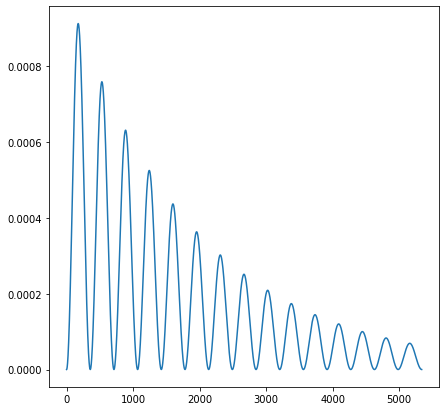

In [0]:
f=np.vectorize(CosineFadeLambda(target_max_lr=1e-4), otypes=[float])
x=np.arange(1,60*89)
y=f(x)
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(7, 7))
#ax.set(yscale="log")
sns.lineplot(x=x,y=y, ax=ax)

In [0]:
def validation(model, val_loader, dev,criterion,epoch):
  classes_num = [168,11,7]
  accum_cf = [np.zeros((c,c+1), dtype=np.int64) for c in classes_num]
  perfd = pd.DataFrame(columns=['root','vowel','cons','mtr','loss'])
  for i, (imgid, batch, y) in enumerate(val_loader):
    try:
      batch_c = batch.to(dev)
      batch_c = batch_c.repeat(1,3,1,1)
      y_c = y.to(dev)
      pred_y = model(batch_c)
      outputs1, outputs2, outputs3 = pred_y[:,: 168], pred_y[:,168: 168+11], pred_y[:,168+11:]
      loss1 = criterion(outputs1,y_c[:, 0])
      loss2 = criterion(outputs2,y_c[:, 1])
      loss3 = criterion(outputs3,y_c[:, 2])
      loss = 2 * loss1 + loss2 + loss3
      val_loss = loss.item()
      metrics, cfs = calc_metrics(y_c.T, [outputs1, outputs2, outputs3], classes_num, calc_cf=True)
      perfd = perfd.append(pd.Series(metrics + [val_loss], index=perfd.columns), ignore_index=True)
      for i in range(len(classes_num)):
        accum_cf[i] += cfs[i]
    except KeyboardInterrupt as e:
      print('Interrupted validation')
      raise
    finally:
      del batch_c, y_c, pred_y

  avperf = perfd.mean(axis=0).tolist()
  print(f'E{epoch + 1}; root:{avperf[0]:.5f}; vowel:{avperf[1]:.5f}; cons:{avperf[2]:.5f}; metric:{avperf[3]:.5f}; avgloss:{avperf[4]:.5f}; ')
  gc.collect()
  if dev == 'cuda':
    torch.cuda.empty_cache()
  return avperf, accum_cf


def train(model, train_loader, val_loader, dev, num_epoch=100, init_lr=0.001, max_metric_in = 0.8, accum_steps = 1):
  classes_num = [168,11,7]
  criterion = nn.CrossEntropyLoss()
  gd = torch.optim.AdamW(model.parameters(),lr=init_lr, amsgrad=True)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=gd, T_max = len(train_loader)*2, eta_min=1e-7)
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gd, mode='min', factor=0.7, patience=5, min_lr=1e-10)
  #scheduler = FixedLambdaLR(optimizer=gd, lr_lambda=CosineFadeLambda(max_lr=init_lr, min_lr=1e-7, target_max_lr=init_lr/10, target_epoch=100, epoch_steps=len(train_loader)/accum_steps, freq_epochs=3))
  max_metric = max_metric_in

  #model.train(True)
  for epoch in range(num_epoch):
    model.train(True)
    d = tqdm(train_loader, ncols=1000)
    perfd = pd.DataFrame(columns=['root','vowel','cons','mtr','loss'])
    train_losses = []
    gd.zero_grad()
    for i, (imgid, batch, y) in enumerate(d):      
      try:
        batch_c = batch.to(dev)
        batch_c = batch_c.repeat(1,3,1,1)
        y_c = y.to(dev)
        pred_y = model(batch_c)
        outputs1, outputs2, outputs3 = pred_y[:,: 168], pred_y[:,168: 168+11], pred_y[:,168+11:]
        loss1 = criterion(outputs1,y_c[:, 0])
        loss2 = criterion(outputs2,y_c[:, 1])
        loss3 = criterion(outputs3,y_c[:, 2])
        loss = 2 * loss1 + loss2 + loss3
        (loss).backward()
        train_loss = loss.item()
        train_losses.append(train_loss)
        metrics, _ = calc_metrics(y_c.T, [outputs1, outputs2, outputs3], classes_num = classes_num, calc_cf = False)
        perfd = perfd.append(pd.Series(metrics + [np.mean(train_losses)], index=perfd.columns), ignore_index=True)

        if (i % accum_steps == (accum_steps-1)): # accumulate
          gd.step()
          gd.zero_grad()
          scheduler.step()
          lr = gd.param_groups[0]['lr']
          avperf = perfd[-20:].mean(axis=0).tolist() #
          d.set_description(f'E{epoch + 1}; cur_loss:{train_loss:.5f};  root:{avperf[0]:.3f}; vowel:{avperf[1]:.5f}; cons:{avperf[2]:.5f}; metric:{avperf[3]:.3f}; lr: {lr:.7f}; avgloss: {avperf[4]:.5f}')
          train_losses = []
      except KeyboardInterrupt as e:
        print('Interrupted train')
        return
      finally:
        del batch_c, y_c, pred_y

    model.train(False)
    model.eval()
    with torch.no_grad():
      val_perf, _ = validation(model, val_loader, dev, criterion, epoch)

    if (val_perf[3] > max_metric):
      torch.save(model.state_dict(), f'{root_path}/bengali_res64x110_gm.dense')
      max_metric = val_perf[3]
      print('saved')
    
    gc.collect()
    if dev == 'cuda':
      torch.cuda.empty_cache()

  # end of epoch cycle

In [0]:
gc.collect()
if device == 'cuda':
  torch.cuda.empty_cache()
train(model, train_loader, val_loader, device, num_epoch=120, init_lr=0.001, max_metric_in=0.97566, accum_steps = 4)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
with torch.no_grad():
  model.train(False)
  model.eval()
  val_perf, accum_cfs = validation(model, val_loader, device, criterion=nn.CrossEntropyLoss(),epoch=1)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


E2; root:0.96468; vowel:0.98507; cons:0.97933; metric:0.97344; avgloss:0.26921; 


In [0]:
np.savetxt(f'{root_path}/validation_conf_mat.txt', acf0, delimiter=',', fmt='%d')

In [0]:
a=np.sum(acf0[:,1:], axis=1).tolist()
print(','.join([str(i) for i in a]))
print(len(a))